In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xg

C:\Users\wpson\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
data = pd.read_csv("harvest_data_plus_environmental_data.csv")

In [3]:
data = data[data['SEX'] == 'F'] # subsetting data to just females

## EDA:

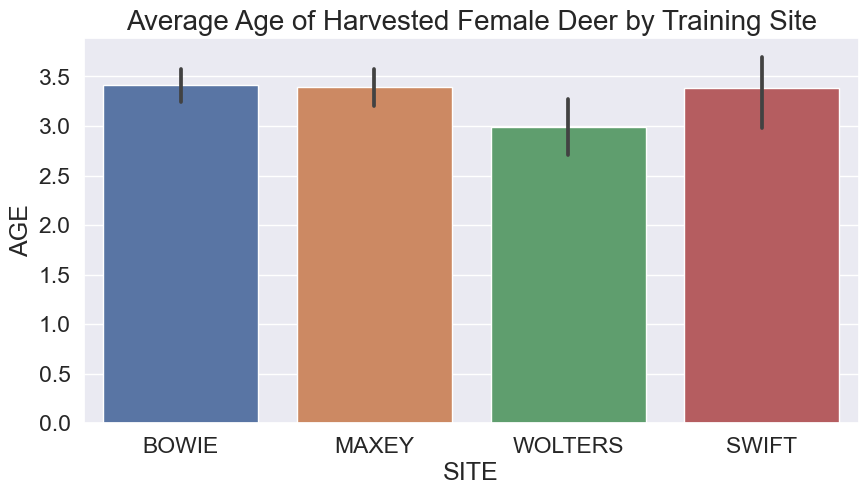

In [4]:
sns.set(rc={"figure.figsize":(10, 5)}, font_scale = 1.5) 
sns.barplot(x = 'SITE', y='AGE', data = data, ci=95)
plt.title('Average Age of Harvested Female Deer by Training Site', fontsize=20)
plt.show()

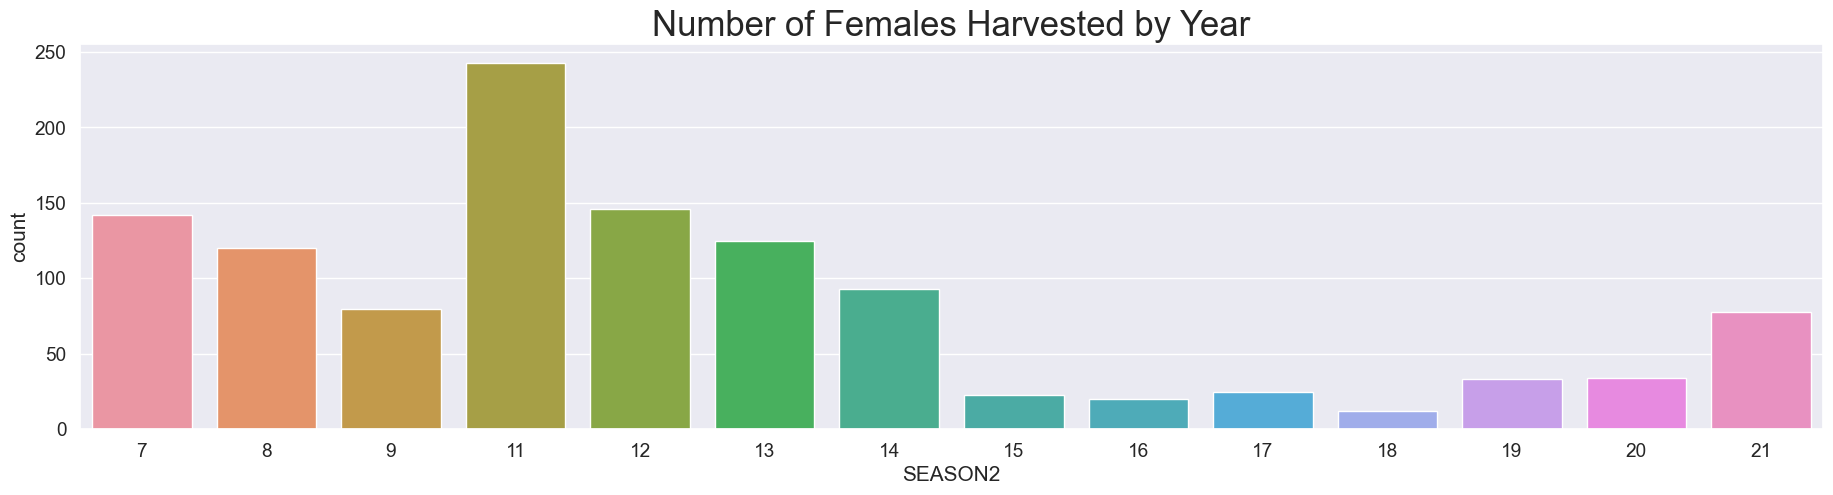

In [5]:
sns.set(rc={"figure.figsize":(22.5, 5)}, font_scale = 1.25) 
sns.countplot(x = 'SEASON2', data = data)
plt.title('Number of Females Harvested by Year', fontsize=25) 
plt.show()

# the x-axis values correspond to year (e.g., '7' = 2007, '10' = 2010, and so on.)

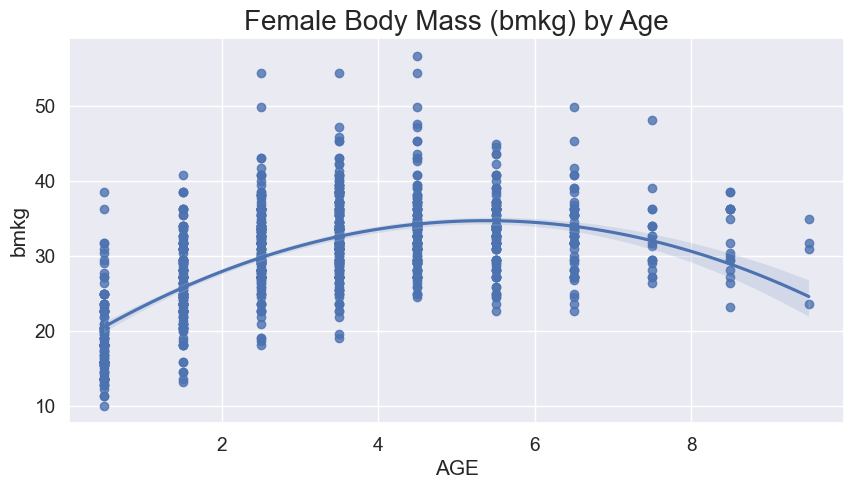

In [6]:
sns.set(rc={"figure.figsize":(10, 5)}, font_scale = 1.25) 
sns.regplot(x = 'AGE', y = 'bmkg', data = data, order=2)
plt.title('Female Body Mass (bmkg) by Age', fontsize=20)
plt.show()

Notice the positive, curvilinear relationship between body mass and age.  However, as males reach about 6 years body mass pleateaus and begins to decline 

In [7]:
data.drop(['PREFIX-ID','SEX','DATE','ID','DATE+#','a,b,etc.','DATE TAKEN','SEASON','SEASONCAT','LIVE.BM.KG',
           'LIVE WEIGHT','BM.LB','POINTS.L','POINTS.R','SPREAD.IN','SPREAD.MM','BASAL.CIR.L.IN',
           'BASAL.CIR.L.MM','BASAL.CIR.R.IN','BASAL.CIR.R.MM ','BEAM.L.IN','BASAL.T.MM','BEAM.L.MM',
           'BEAM.R.IN','BEAM.R.MM','LACTATION','NOTES','beamtmm'],axis=1, inplace=True)

In [8]:
data['SITE'].replace(['BOWIE', 'SWIFT','MAXEY','WOLTERS'],[0, 1, 2, 3], inplace=True)

In [9]:
data.dropna(subset=['bmkg','AGE'],inplace=True)

In [10]:
print("Total NaN in dataframe :" , data.isna().sum().sum())
print("Total NaN in each column of the dataframe")
na = []
for index, col in enumerate(data):
    na.append((index, data[col].isna().sum())) 
na_sorted = na.copy()
na_sorted.sort(key = lambda x: x[1], reverse = True) 

for i in range(len(data.columns)):
    print(data.columns[na_sorted[i][0]],":", na_sorted[i][1], "NaN")

Total NaN in dataframe : 0
Total NaN in each column of the dataframe
SEASON2 : 0 NaN
SITE : 0 NaN
AGE : 0 NaN
bmkg : 0 NaN
rain_lag_0 : 0 NaN
rain_lag_1 : 0 NaN
rain_lag_2 : 0 NaN
rain_lag_3 : 0 NaN
rain_lag_4 : 0 NaN
rain_lag_5 : 0 NaN
temp_0 : 0 NaN
temp_1 : 0 NaN
temp_2 : 0 NaN
temp_3 : 0 NaN
temp_4 : 0 NaN
temp_5 : 0 NaN


Text(0.5, 1.0, 'Average age of harvested female deer by training site')

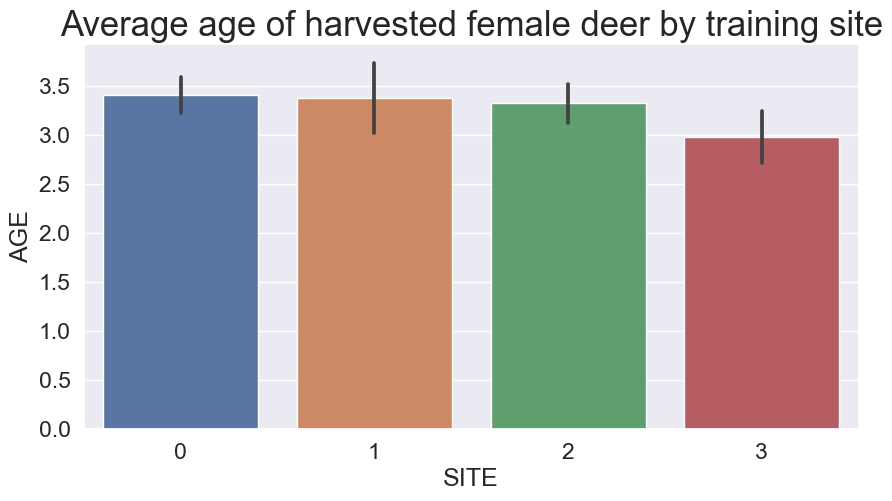

In [11]:
sns.set(rc={"figure.figsize":(10, 5)}, font_scale = 1.5) 
sns.barplot(x = 'SITE', y='AGE', data = data, ci=95)
plt.title('Average age of harvested female deer by training site', fontsize=25)

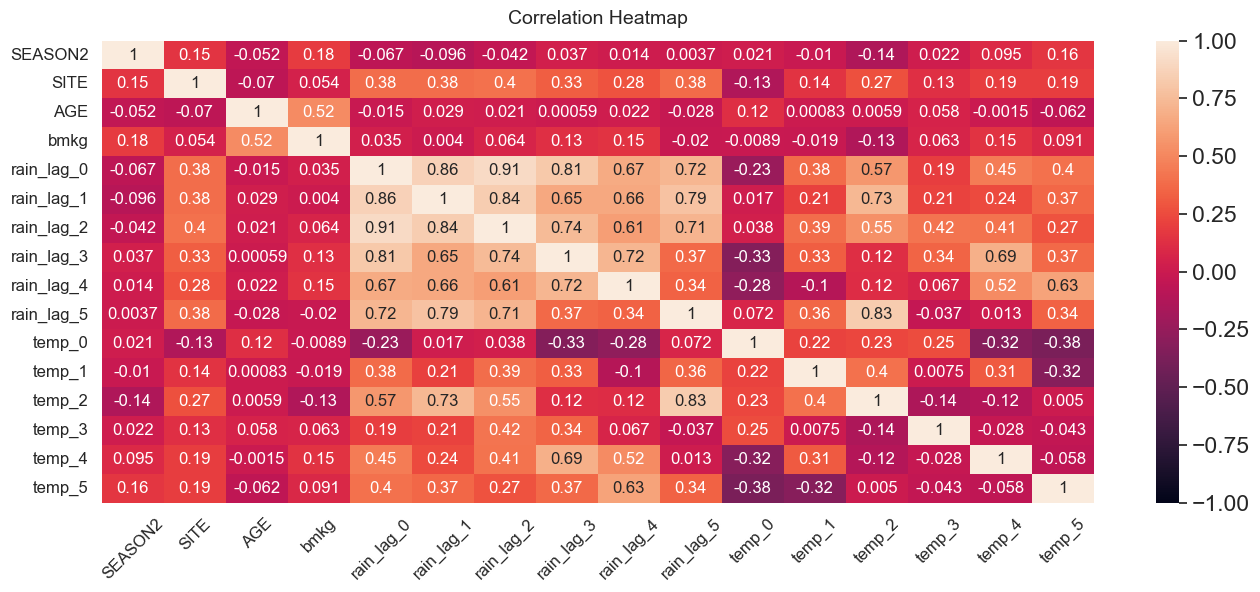

In [12]:
# Looking at correlations then dropping highly correlated variables
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, annot_kws={"size":12})
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);
plt.xticks(rotation = 45)
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)
plt.show()

Kept rain lag 3 and 4 because they are the only rain lags that don't correlate highly with other rain lags

In [13]:
X = data[['AGE','SITE','SEASON2', 'rain_lag_4', 'rain_lag_3','rain_lag_5','temp_0','temp_1','temp_2','temp_3','temp_4','temp_5']] 
y = data['bmkg']

Fit several linear regression models and select final model

In [14]:
lm1 = smf.ols(formula='bmkg ~ AGE + SITE + SEASON2 + rain_lag_4 + rain_lag_3 + rain_lag_5 + temp_0 + temp_1 + temp_2 + temp_3 + temp_4 + temp_5', data=data).fit()
lm2 = smf.ols(formula='bmkg ~ AGE + SITE + SEASON2 + rain_lag_4 + rain_lag_3 + temp_0 + temp_1 + temp_2 + temp_3 + temp_4 + temp_5', data=data).fit()
lm3 = smf.ols(formula='bmkg ~ AGE + SITE + SEASON2 + rain_lag_4 + temp_0 + temp_1 + temp_2 + temp_3 + temp_4 + temp_5', data=data).fit()
lm4 = smf.ols(formula='bmkg ~ AGE + SITE + SEASON2 + rain_lag_4 + temp_0 + temp_1 + temp_2 + temp_3 + temp_4 + temp_5', data=data).fit()
lm5 = smf.ols(formula='bmkg ~ AGE + SITE + SEASON2 + rain_lag_3 + temp_0 + temp_1 + temp_2 + temp_3 + temp_4 + temp_5', data=data).fit()
lm6 = smf.ols(formula='bmkg ~ AGE + SITE + SEASON2 + rain_lag_4 + rain_lag_3 + rain_lag_5 + temp_0 + temp_1 + temp_2 + temp_3 + temp_4', data=data).fit()
lm7 = smf.ols(formula='bmkg ~ AGE + SITE + SEASON2 + rain_lag_4 + rain_lag_3 + rain_lag_5 + temp_0 + temp_1 + temp_2 + temp_3', data=data).fit()
lm8 = smf.ols(formula='bmkg ~ AGE + SITE + SEASON2 + rain_lag_4 + rain_lag_3 + rain_lag_5 + temp_0 + temp_1 + temp_2', data=data).fit()
lm9 = smf.ols(formula='bmkg ~ AGE + SITE + SEASON2 + rain_lag_4 + rain_lag_3 + rain_lag_5 + temp_0 + temp_1', data=data).fit()
lm10 = smf.ols(formula='bmkg ~ AGE + SITE + SEASON2 + rain_lag_4 + rain_lag_3 + rain_lag_5 + temp_0', data=data).fit()
lm11 = smf.ols(formula='bmkg ~ AGE + SITE + SEASON2 + rain_lag_4 + rain_lag_3 + rain_lag_5', data=data).fit()
lm12 = smf.ols(formula='bmkg ~ AGE + SEASON2 + rain_lag_4 + rain_lag_3 + rain_lag_5', data=data).fit()
lm13 = smf.ols(formula='bmkg ~ AGE + rain_lag_4 + rain_lag_3 + rain_lag_5', data=data).fit()

print(lm1.aic) 
print(lm2.aic)
print(lm3.aic)
print(lm4.aic)
print(lm5.aic)
print(lm6.aic)
print(lm7.aic)
print(lm8.aic) # lowest AIC score
print(lm9.aic)
print(lm9.aic)
print(lm10.aic)
print(lm11.aic)
print(lm12.aic)
print(lm13.aic)


6601.0862366156
6609.873991520157
6607.874292415408
6607.874292415408
6608.570197082403
6599.186646157487
6598.912473427788
6597.700268344508
6627.59719089739
6627.59719089739
6625.598880873441
6624.205748056653
6624.414762981105
6687.587374613844


In [15]:
print(lm1.bic) 
print(lm2.bic)
print(lm3.bic)
print(lm4.bic)
print(lm5.bic)
print(lm6.bic)
print(lm7.bic)
print(lm8.bic) # lowest BIC score
print(lm9.bic)
print(lm9.bic)
print(lm10.bic)
print(lm11.bic)
print(lm12.bic)
print(lm13.bic) 

6665.471708995723
6669.306735255655
6662.354307506281
6662.354307506281
6663.050212173276
6658.619389892986
6653.392488518662
6647.227554790757
6672.171748699014
6672.171748699014
6665.2207100304395
6658.874848569027
6654.131134848854
6712.351017836969


AIC and BIC report lowest score for the same model, lm8 
lm8 = 'bmkg ~ AGE + SITE + SEASON2 + rain_lag_4 + rain_lag_3 + rain_lag_5 + temp_0 + temp_1 + temp_2'

In [16]:
lm8.summary() # Not a great r2

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   bmkg   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     65.43
Date:                Wed, 14 Dec 2022   Prob (F-statistic):           4.55e-95
Time:                        16:15:11   Log-Likelihood:                -3288.9
No. Observations:                1046   AIC:                             6598.
Df Residuals:                    1036   BIC:                             6647.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.2588     13.040      0.403      0.687     -20.329      30.846
AGE            1.9265      0.090     21.428      0.000       1.750       2.103
SITE           0.2840      0.160      1.779      0.076      -0.029       0.597
SEASON2        0.2927      0.048      6.107      0.000       0.199       0.387
rain_lag_4     0.0569      0.022      2.544      0.011       0.013       0.101
rain_lag_3    -0.0099      0.021     -0.463      0.644      -0.052       0.032
rain_lag_5     0.0669      0.020      3.298      0.001       0.027       0.107
temp_0     -4.838e-05      0.000     -0.123      0.902      -0.001       0.001
temp_1         0.0007      0.001      1.429      0.153      -0.000       0.002
temp_2        -0.0003   4.64e-05     -5.664      0.000      -0.000      -0.000
==============================================================================
Omnibus:                       34.055   Durbin-Watson:                   1.813
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.704
Skew:                           0.306   Prob(JB):                     1.61e-11
Kurtosis:                       3.875   Cond. No.                     3.26e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.26e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [17]:
pred = lm8.predict(X)
print(pred)

0       31.741950
1       25.962477
2       27.888968
3       33.668441
4       35.594932
          ...    
1574    33.547196
1575    35.473687
1576    35.473687
1578    29.694214
1579    33.547196
Length: 1046, dtype: float64


In [18]:
mae = mean_absolute_error(y, pred)
print("mean absolute error for the MLR {}".format(mae))

mean absolute error for the MLR 4.373562562969659


Contrast performance and results of linear model with a few machine learning models to see if predictors' feature importances vary among models

In [19]:
rf = RandomForestRegressor(random_state = 1)
gb = GradientBoostingRegressor(random_state = 1)
xgbr = xg.XGBRegressor(random_state = 1)

KFold cross validation to assess overfit

In [20]:
scores_rf = cross_val_score(rf,X,y,scoring="neg_mean_absolute_error",cv=10)
mae_rf = (-scores_rf)
print("MAE values: ", mae_rf)
print("MAE average: ", np.mean(mae_rf))

MAE values:  [4.26910872 4.43534045 3.43443049 3.68598376 3.85080407 4.31603365
 3.5944259  4.34464381 4.05658615 4.50638607]
MAE average:  4.0493743069450945


In [21]:
scores_gb = cross_val_score(gb,X,y,scoring="neg_mean_absolute_error",cv=10)
mae_gb = (-scores_gb)
print("MAE values: ", mae_gb)
print("MAE average: ", np.mean(mae_gb))

MAE values:  [4.13820667 4.68490388 3.43993101 3.25539393 4.09830336 4.24795594
 4.00180737 4.34112959 4.04018128 4.34363341]
MAE average:  4.05914464338896


In [22]:
scores_xgbr = cross_val_score(xgbr,X,y,scoring="neg_mean_absolute_error",cv=10)
mae_xgbr = (-scores_xgbr)
print("MAE values: ", mae_xgbr)
print("MAE average: ", np.mean(mae_xgbr))

C:\Users\wpson\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\wpson\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\wpson\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\wpson\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future

MAE values:  [4.36388633 4.88956013 3.60182795 3.82060901 4.17886525 4.7165625
 4.01820513 4.1341485  4.30420903 5.11534552]
MAE average:  4.314321934960644


C:\Users\wpson\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Tune hyperparamters via grid search 

In [23]:
params = [{'n_estimators':np.arange(5,100,5),
           'max_features':np.arange(0.1,1.0,0.05)}]

In [24]:
gs_rf = GridSearchCV(estimator = rf, 
                           param_grid = params,
                           cv=5, 
                           scoring="neg_mean_absolute_error",
                           verbose=1,
                           n_jobs=-1)

In [25]:
gs_gb = GridSearchCV(estimator = gb, 
                           param_grid = params,
                           cv=5, 
                           scoring="neg_mean_absolute_error",
                           verbose=1,
                           n_jobs=-1)

In [26]:
gs_xgbr = GridSearchCV(estimator = xgbr, 
                           param_grid = params,
                           cv=5, 
                           scoring="neg_mean_absolute_error",
                           verbose=1,
                           n_jobs=-1)

In [27]:
gs_rf.fit(X,y)

Fitting 5 folds for each of 342 candidates, totalling 1710 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1), n_jobs=-1,
             param_grid=[{'max_features': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                          'n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95])}],
             scoring='neg_mean_absolute_error', verbose=1)

In [28]:
gs_gb.fit(X,y)

Fitting 5 folds for each of 342 candidates, totalling 1710 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=1),
             n_jobs=-1,
             param_grid=[{'max_features': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                          'n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95])}],
             scoring='neg_mean_absolute_error', verbose=1)

In [29]:
gs_xgbr.fit(X,y)

Fitting 5 folds for each of 342 candidates, totalling 1710 fits
[16:21:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\wpson\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n...
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_parameters=None, verbosity=None),
             n_jobs=-1,
             param_grid=[{'max_features': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                          'n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95])}],
             scoring='neg_mean_absolute_error', verbose=1)

In [30]:
pred_gs_rf = gs_rf.predict(X)
pred_gs_gb = gs_gb.predict(X)
pred_gs_xgbr = gs_xgbr.predict(X)

mae_gs_rf = mean_absolute_error(y, pred_gs_rf)
mae_gs_gb = mean_absolute_error(y, pred_gs_gb)
mae_gs_xgbr = mean_absolute_error(y, pred_gs_xgbr)

print(mae_gs_rf) # lowest mae
print(mae_gs_gb)
print(mae_gs_xgbr)

3.1624463392999096
3.5451129124465717
3.3309659270278753


Assess if predictors have similar feature importance scores among models

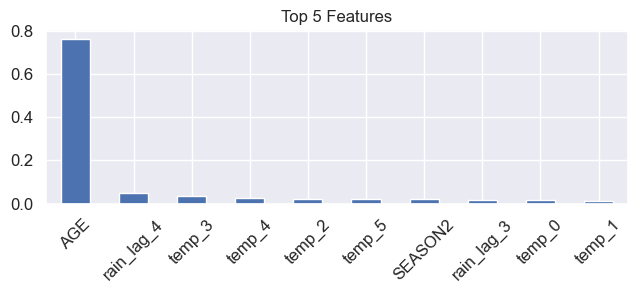

In [34]:
# lowest mae of the 3 ML models

feat_importances = pd.Series(gs_rf.best_estimator_.feature_importances_, index=X.columns)
plt.figure(figsize=(7.5, 2.25))
feat_importances.nlargest(10).plot(kind='bar')
titlefont = 12
plt.title("Top 5 Features", fontdict={'fontsize':titlefont})
plt.xticks(rotation = 45) 
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)
plt.show()

# Interpretation: Age is clearly important in predicting female body mass.  
# rain_lag_4 was the second most important feature.  However, all variables, except for AGE were pretty unexplantory. 

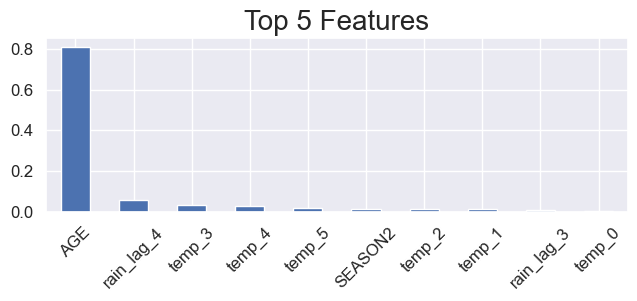

In [32]:
feat_importances = pd.Series(gs_gb.best_estimator_.feature_importances_, index=X.columns)
plt.figure(figsize=(7.5, 2.25))
feat_importances.nlargest(10).plot(kind='bar')
titlefont = 20
plt.title("Top 5 Features", fontdict={'fontsize':titlefont})
plt.xticks(rotation = 45)
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)
plt.show()

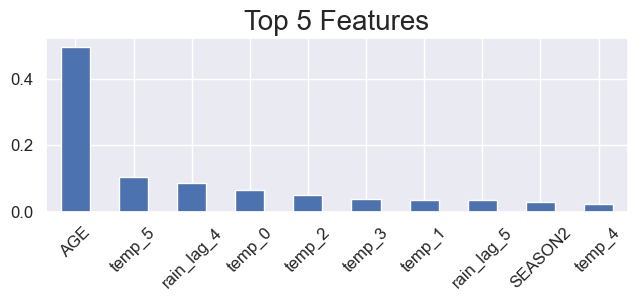

In [33]:
feat_importances = pd.Series(gs_xgbr.best_estimator_.feature_importances_, index=X.columns)
plt.figure(figsize=(7.5, 2.25))
feat_importances.nlargest(10).plot(kind='bar')
titlefont = 20
plt.title("Top 5 Features", fontdict={'fontsize':titlefont})
plt.xticks(rotation = 45) 
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)
plt.show()